# Setup: Install Necessary Libraries
 The required libraries are installed for time series forecasting and data manipulation:

In [1]:
!pip install -Uqq nixtla datasetsforecast utilsforecast


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.8 MB/s eta 0:00:00


# Import Necessary Libraries
We import essential modules for handling data, plotting, and using TimeGPT:

In [2]:
from nixtla.utils import in_colab
import pandas as pd
from nixtla import NixtlaClient
from google.colab import userdata
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae

IN_COLAB = in_colab()


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# API Key Setup
Retrieve and initialize the API key securely:

In [5]:
NIXTLA_API_KEY = userdata.get('NIXTLA_API_KEY')
nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)


Load Example Data
The electricity dataset is used for demonstrating multiple series forecasting:

In [17]:
# Load the sample dataset for electricity consumption
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')

# Preview the first few rows of the dataset
df.head()


,unique_id,ds,y
0,BE,2016-10-22 00:00:00,70.00
1,BE,2016-10-22 01:00:00,37.10
2,BE,2016-10-22 02:00:00,37.10
3,BE,2016-10-22 03:00:00,44.75
4,BE,2016-10-22 04:00:00,37.10


# Visualize the Data
Visualize the data to understand its trends and behavior:

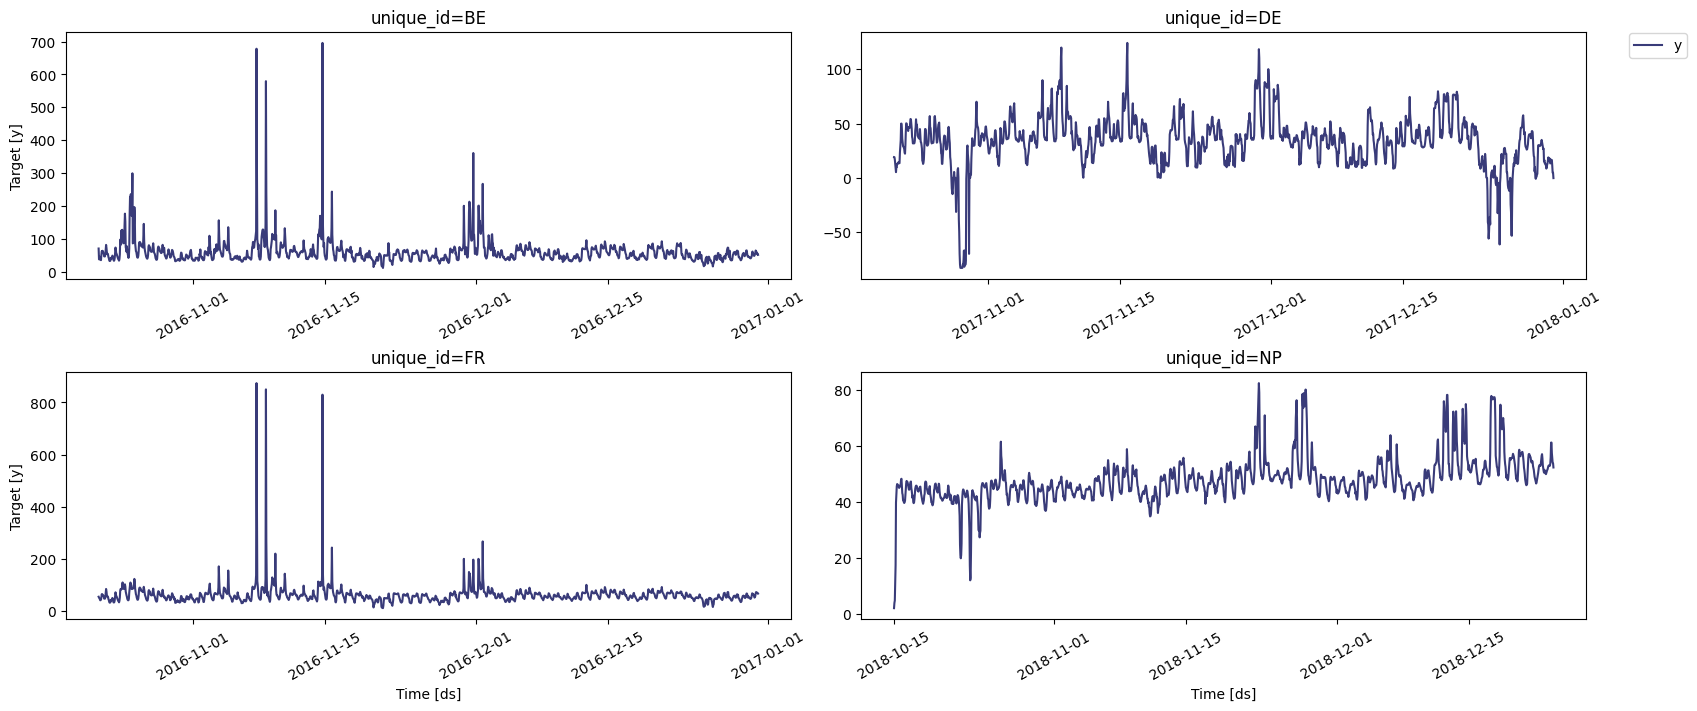

In [7]:
nixtla_client.plot(df)


# Multiple Series Forecasting
Predict future values for multiple time series:

In [18]:
# Perform multiple series forecasting for the next 24 time steps with confidence intervals
forecast_df = nixtla_client.forecast(df=df, h=24, level=[80, 90])

# Preview the forecasted results
forecast_df.head()


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,45.191200,54.872765,57.370620,35.509636,33.011780
1,BE,2016-12-31 01:00:00,43.245210,51.114510,56.101950,35.375908,30.388466
2,BE,2016-12-31 02:00:00,41.959000,48.577030,54.632755,35.340970,29.285244
3,BE,2016-12-31 03:00:00,39.797043,47.267212,49.683910,32.326874,29.910175
4,BE,2016-12-31 04:00:00,39.205093,47.410007,47.678200,31.000177,30.731985


# Plot the Forecast Results
Visualize the forecasted values alongside the original data:

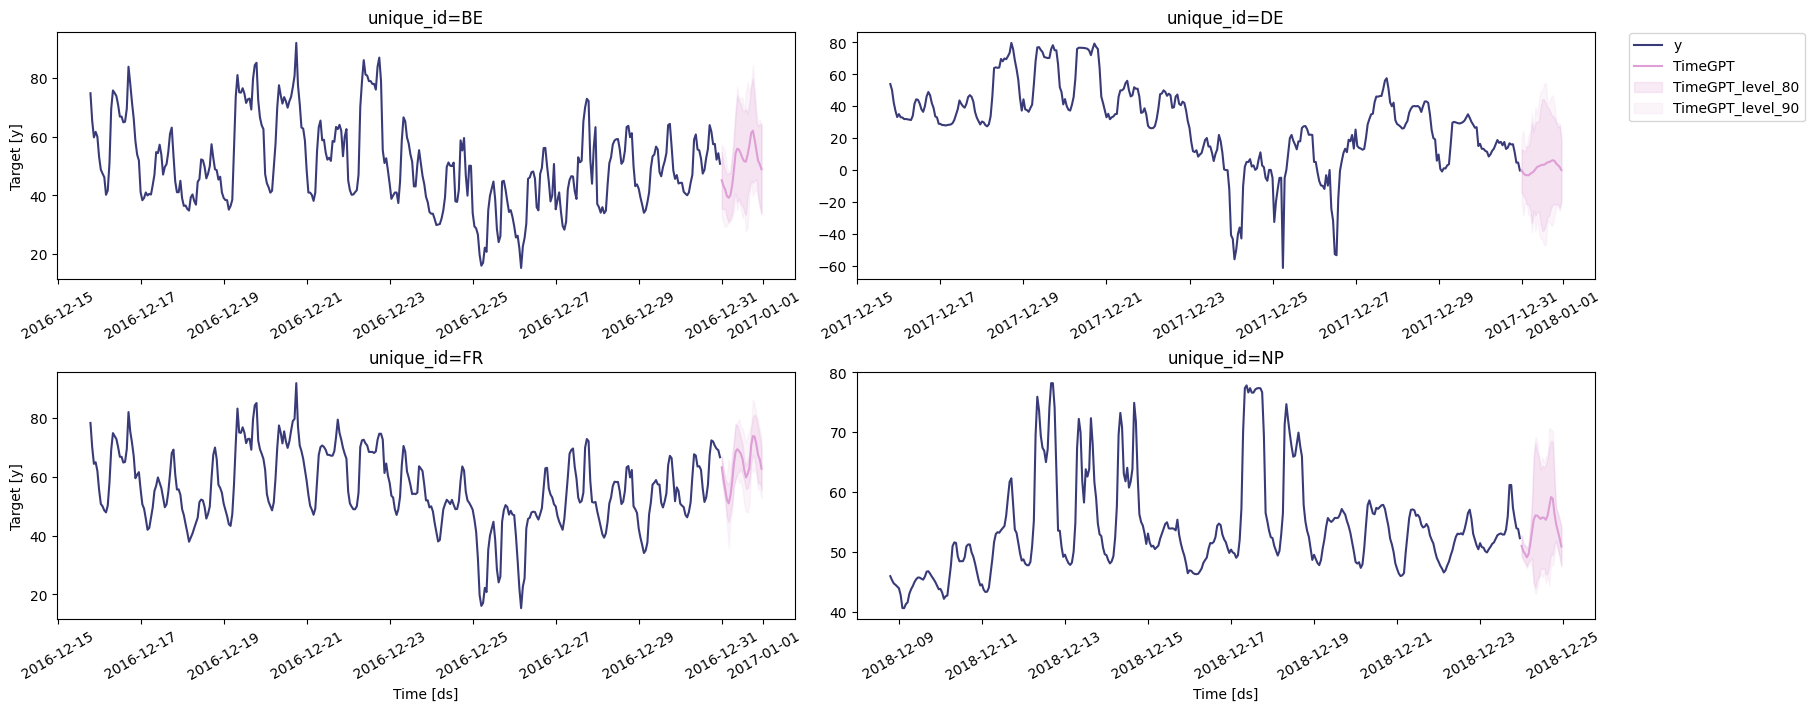

In [19]:
# Plot the forecast results
nixtla_client.plot(df, forecast_df, max_insample_length=365, level=[80, 90])


# Historical Forecasting
Generate forecasts while including historical data for comparison:

In [20]:
# Perform forecasting with historical data included
forecast_with_history = nixtla_client.forecast(df=df, h=24, level=[80, 90], add_history=True)

# Preview the results with historical data
forecast_with_history.head()


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-10-27 00:00:00,56.072560,98.19364,110.134380,13.951481,2.010740
1,BE,2016-10-27 01:00:00,52.413048,94.53413,106.474870,10.291969,-1.648771
2,BE,2016-10-27 02:00:00,52.805850,94.92693,106.867670,10.684772,-1.255968
3,BE,2016-10-27 03:00:00,52.581253,94.70233,106.643074,10.460175,-1.480566
4,BE,2016-10-27 04:00:00,52.667156,94.78824,106.728970,10.546078,-1.394663


# Visualize Historical Data and Forecast
Compare the historical data with forecasted values for better context:




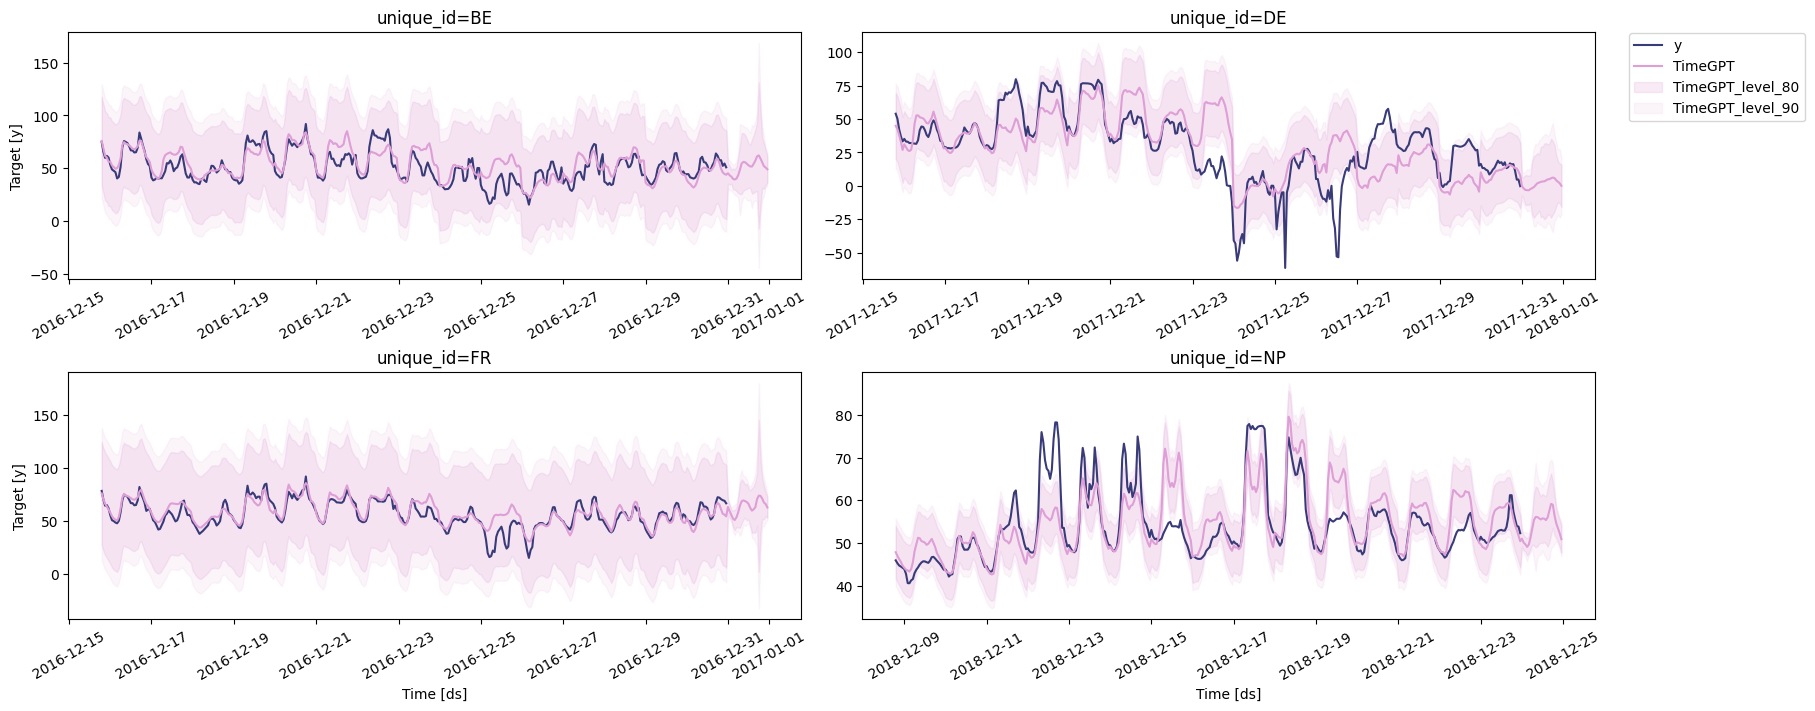

In [21]:
# Visualize historical data with forecasted values
nixtla_client.plot(
    df,
    forecast_with_history.groupby('unique_id').tail(365 + 24),
    max_insample_length=365,
    level=[80, 90]
)


# Long-Horizon Forecasting
For datasets requiring longer forecast horizons:

In [12]:
Y_df, *_ = LongHorizon.load(directory='./', group='ETTh1')
Y_df.head()


100%|██████████| 314M/314M [00:14<00:00, 22.1MiB/s]


,unique_id,ds,y
0,OT,2016-07-01 00:00:00,1.460552
1,OT,2016-07-01 01:00:00,1.161527
2,OT,2016-07-01 02:00:00,1.161527
3,OT,2016-07-01 03:00:00,0.862611
4,OT,2016-07-01 04:00:00,0.525227


### Prepare the input sequence and test data

In [13]:
test = Y_df[-96:]
input_seq = Y_df[-1104:-96]


Perform long-horizon forecasting:

In [22]:
# Perform forecasting for a long horizon using TimeGPT
long_horizon_forecast = nixtla_client.forecast(
    df=input_seq,
    h=96,
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)


Visualize the long-horizon forecast results:

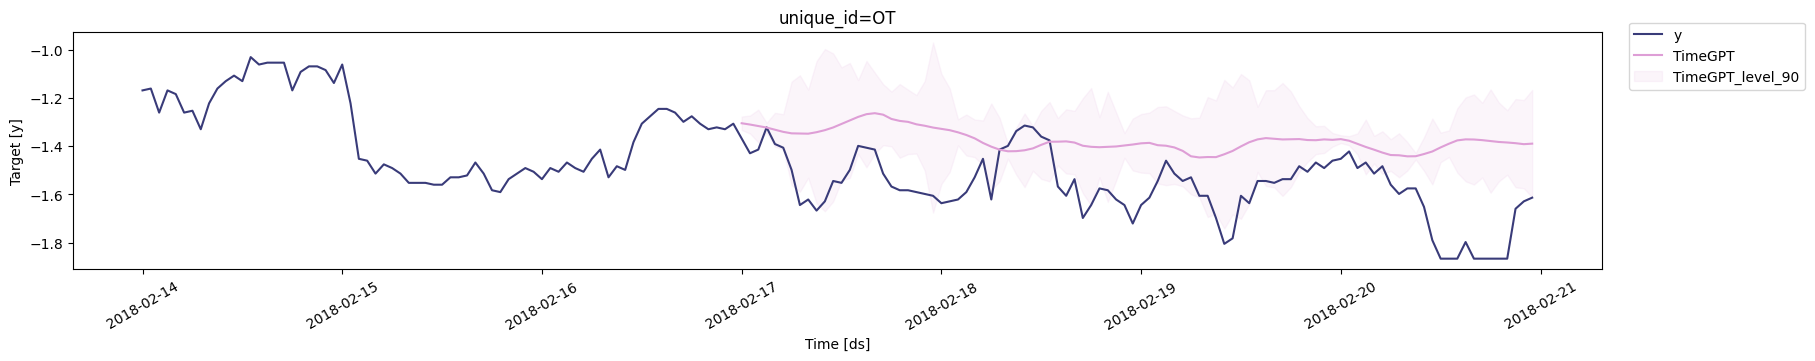

In [23]:
# Plot the results of the long-horizon forecast
nixtla_client.plot(Y_df[-168:], long_horizon_forecast, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')


# Evaluate the Model
Evaluate the model performance using MAE:



In [24]:
# Add the forecasted values to the test set
test = test.copy()
test['TimeGPT'] = long_horizon_forecast['TimeGPT'].values

# Compute Mean Absolute Error (MAE) for evaluation
evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')

# Print the evaluation results
print(evaluation)


  unique_id   TimeGPT
0        OT  0.205319
